Code adapted from https://abhinavcreed13.github.io/blog/bengio-trigram-nplm-using-pytorch/

In [12]:
#load wikitext data

train = []
test = []

train_file_path = '../newtraincorpus.txt'
test_file_path = '../newtestcorpus.txt'

with open(train_file_path, 'r', encoding='utf-8') as file:
    for line in file:
            # Process each line as a sentence
            words = (line.strip().split())
            train.append(words)

with open(test_file_path, 'r', encoding='utf-8') as file:
    for line in file:
            # Process each line as a sentence
            words = (line.strip().split())
            test.append(words)

print(len(train))
print(len(test))

77363
9418


In [13]:
#split everything into chars

char_train = []
for list in train:
    chars = []
    for string in list:
        for char in string:
            chars.append(char)
    char_train.append(chars)

char_test = []
for list in test:
    chars = []
    for string in list:
        for char in string:
            chars.append(char)
    char_test.append(chars)

train = char_train
test = char_test

In [14]:
train[0]

['v',
 'a',
 'l',
 'k',
 'y',
 'r',
 'i',
 'a',
 'o',
 'f',
 't',
 'h',
 'e',
 'b',
 'a',
 't',
 't',
 'l',
 'e',
 'f',
 'i',
 'e',
 'l',
 'd',
 '<',
 'n',
 'u',
 'm',
 '>',
 'c',
 'o',
 'm',
 'm',
 'o',
 'n',
 'l',
 'y',
 'r',
 'e',
 'f',
 'e',
 'r',
 'r',
 'e',
 'd',
 't',
 'o',
 'a',
 's',
 'v',
 'a',
 'l',
 'k',
 'y',
 'r',
 'i',
 'a',
 'c',
 'h',
 'r',
 'o',
 'n',
 'i',
 'c',
 'l',
 'e',
 's',
 'i',
 'i',
 'i',
 'o',
 'u',
 't',
 's',
 'i',
 'd',
 'e',
 'j',
 'a',
 'p',
 'a',
 'n',
 'i',
 's',
 'a',
 't',
 'a',
 'c',
 't',
 'i',
 'c',
 'a',
 'l',
 'r',
 'o',
 'l',
 'e',
 '@',
 '-',
 '@',
 'p',
 'l',
 'a',
 'y',
 'i',
 'n',
 'g',
 'v',
 'i',
 'd',
 'e',
 'o',
 'g',
 'a',
 'm',
 'e',
 'd',
 'e',
 'v',
 'e',
 'l',
 'o',
 'p',
 'e',
 'd',
 'b',
 'y',
 's',
 'e',
 'g',
 'a',
 'a',
 'n',
 'd',
 'm',
 'e',
 'd',
 'i',
 'a']

In [18]:
#create vocabulary


UNK_symbol = "<UNK>"
vocab = set([UNK_symbol])



# create term frequency of the words
words_term_frequency_train = {}
for doc in train:
    for word in doc:
        # this will calculate term frequency
        # since we are taking all words now
        words_term_frequency_train[word] = words_term_frequency_train.get(word,0) + 1

# create vocabulary
for doc in train:
    for word in doc:
        if words_term_frequency_train.get(word,0) >= 5:
            vocab.add(word)



print(len(vocab))

204


In [19]:
#create 5-grams

import numpy as np
# create required lists
x_train = []
y_train = []

x_test = []
y_test = []


# create word to id mappings
word_to_id_mappings = {}
for idx,word in enumerate(vocab):
    word_to_id_mappings[word] = idx

# function to get id for a given word
# return <UNK> id if not found
def get_id_of_word(word):
    unknown_word_id = word_to_id_mappings['<UNK>']
    return word_to_id_mappings.get(word,unknown_word_id)

# creating training and dev set
for sentence in train:
    for i,word in enumerate(sentence):
        if i+4 >= len(sentence):
            # sentence boundary reached
            break
        # convert word to id
        x_extract = [get_id_of_word(word),get_id_of_word(sentence[i+1]),get_id_of_word(sentence[i+2]), get_id_of_word(sentence[i+3])]
        y_extract = [get_id_of_word(sentence[i+4])]

        x_train.append(x_extract)
        y_train.append(y_extract)

for sentence in test:
    for i,word in enumerate(sentence):
        if i+4 >= len(sentence):
            # sentence boundary reached
            # ignoring sentence less than 3 words
            break
        # convert word to id
        x_extract = [get_id_of_word(word),get_id_of_word(sentence[i+1]),get_id_of_word(sentence[i+2]), get_id_of_word(sentence[i+3])]
        y_extract = [get_id_of_word(sentence[i+4])]

        x_test.append(x_extract)
        y_test.append(y_extract)
  

# making numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)  
  
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(7631548, 4)
(7631548, 1)
(884258, 4)
(884258, 1)


In [21]:
# load libraries
import torch
import multiprocessing
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import time

In [23]:
# 5gramgram Neural Network Model
class fiveGramNNmodel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size, h):
        super(fiveGramNNmodel, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, h)
        self.linear2 = nn.Linear(h, vocab_size, bias = False)

    def forward(self, inputs):
        # compute x': concatenation of x1 and x2 embeddings
        embeds = self.embeddings(inputs).view((-1,self.context_size * self.embedding_dim))
        # compute h: tanh(W_1.x' + b)
        out = torch.tanh(self.linear1(embeds))
        # compute W_2.h
        out = self.linear2(out)
        # compute y: log_softmax(W_2.h)
        log_probs = F.log_softmax(out, dim=1)
        # return log probabilities
        # BATCH_SIZE x len(vocab)
        return log_probs

In [31]:
# create parameters
gpu = 0 
# word vectors size
EMBEDDING_DIM = 50
CONTEXT_SIZE = 4
BATCH_SIZE = 256
# hidden units
H = 200
torch.manual_seed(13013)

# check if gpu is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
available_workers = multiprocessing.cpu_count()

print("--- Creating training and dev dataloaders with {} batch size ---".format(BATCH_SIZE))
train_set = np.concatenate((x_train, y_train), axis=1)
test_set = np.concatenate((x_test, y_test), axis=1)
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, num_workers = available_workers)
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, num_workers = available_workers)

cuda
--- Creating training and dev dataloaders with 256 batch size ---


In [33]:
# helper function to get accuracy from log probabilities
def get_accuracy_from_log_probs(log_probs, labels):
    probs = torch.exp(log_probs)
    predicted_label = torch.argmax(probs, dim=1)
    acc = (predicted_label == labels).float().mean()
    return acc

# helper function to evaluate model on dev data
def evaluate(model, criterion, dataloader, gpu):
    model.eval()

    mean_acc, mean_loss = 0, 0
    count = 0
    losses = []
    with torch.no_grad():
        dev_st = time.time()
        for it, data_tensor in enumerate(dataloader):
            context_tensor = data_tensor[:,0:4].type(torch.LongTensor)
            target_tensor = data_tensor[:,4].type(torch.LongTensor)
            context_tensor, target_tensor = context_tensor.cuda(gpu), target_tensor.cuda(gpu)
            log_probs = model(context_tensor)
            loss = criterion(log_probs, target_tensor)
            mean_loss += loss.item()
            mean_acc += get_accuracy_from_log_probs(log_probs, target_tensor)
            count += 1

                
            if it % 1000 == 0: 
                print("Dev Iteration {} complete. Mean Loss: {}; Mean Acc:{}; Time taken (s): {}".format(it, mean_loss / count, mean_acc / count, (time.time()-dev_st)))
                dev_st = time.time()
                losses.append(loss.item())
    return mean_acc / count, mean_loss / count, losses

import matplotlib.pyplot as plt

def plot_loss(losses, title):
    batches = range(1, len(losses) + 1)
    plt.plot(batches, losses, 'b', label='Training loss')
    plt.title(title)
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [26]:
for it, data_tensor in enumerate(train_loader):       
    print(data_tensor[:,0:4])
    print(data_tensor[:,4])
    break

KeyboardInterrupt: 


--- Training model Epoch: 1 ---
Training Iteration 0 of epoch 0 complete. Loss: 5.342562198638916; Acc:0.0; Time taken (s): 22.0971519947052
Training Iteration 1000 of epoch 0 complete. Loss: 2.2695226669311523; Acc:0.3125; Time taken (s): 1.2600011825561523
Training Iteration 2000 of epoch 0 complete. Loss: 2.4844768047332764; Acc:0.26953125; Time taken (s): 1.084000825881958
Training Iteration 3000 of epoch 0 complete. Loss: 1.9795098304748535; Acc:0.3984375; Time taken (s): 1.086000919342041
Training Iteration 4000 of epoch 0 complete. Loss: 2.040248394012451; Acc:0.3984375; Time taken (s): 1.081000804901123
Training Iteration 5000 of epoch 0 complete. Loss: 2.194150447845459; Acc:0.3515625; Time taken (s): 1.076000690460205
Training Iteration 6000 of epoch 0 complete. Loss: 1.772530198097229; Acc:0.484375; Time taken (s): 1.084000587463379
Training Iteration 7000 of epoch 0 complete. Loss: 1.3977373838424683; Acc:0.625; Time taken (s): 1.0750007629394531
Training Iteration 8000 of

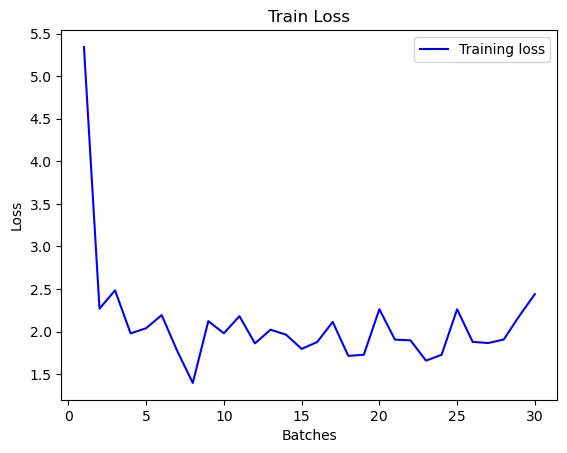

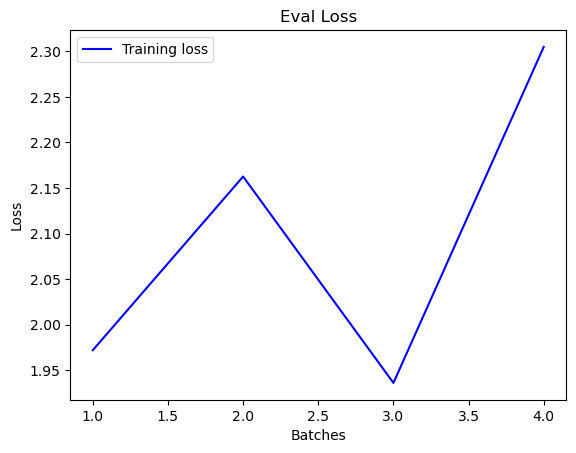

Best development accuracy improved from 0 to 0.39591535925865173, saving model...

--- Training model Epoch: 2 ---
Training Iteration 0 of epoch 1 complete. Loss: 2.004378080368042; Acc:0.421875; Time taken (s): 21.759209394454956
Training Iteration 1000 of epoch 1 complete. Loss: 2.0297226905822754; Acc:0.41015625; Time taken (s): 1.4550011157989502
Training Iteration 2000 of epoch 1 complete. Loss: 2.2788915634155273; Acc:0.359375; Time taken (s): 1.200000524520874
Training Iteration 3000 of epoch 1 complete. Loss: 1.920217514038086; Acc:0.4375; Time taken (s): 1.219001054763794
Training Iteration 4000 of epoch 1 complete. Loss: 1.9771878719329834; Acc:0.42578125; Time taken (s): 1.2420010566711426
Training Iteration 5000 of epoch 1 complete. Loss: 2.1904141902923584; Acc:0.34765625; Time taken (s): 1.2280004024505615
Training Iteration 6000 of epoch 1 complete. Loss: 1.6914550065994263; Acc:0.5; Time taken (s): 1.2200007438659668
Training Iteration 7000 of epoch 1 complete. Loss: 1.

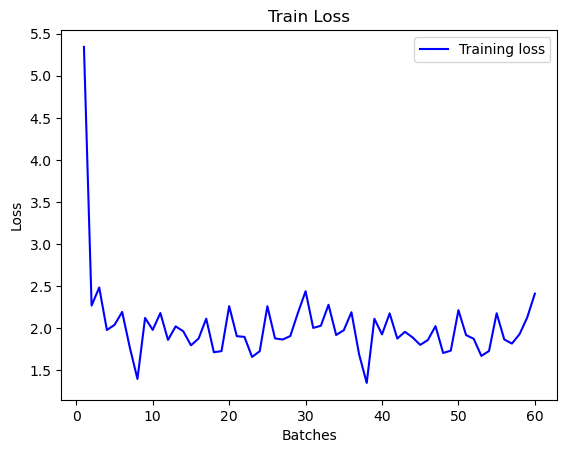

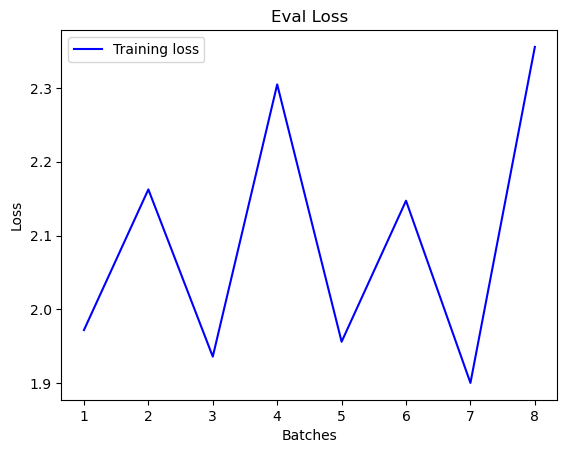

Best development accuracy improved from 0.39591535925865173 to 0.4056329131126404, saving model...

--- Training model Epoch: 3 ---
Training Iteration 0 of epoch 2 complete. Loss: 1.9687246084213257; Acc:0.453125; Time taken (s): 21.84203815460205
Training Iteration 1000 of epoch 2 complete. Loss: 1.996546745300293; Acc:0.41015625; Time taken (s): 1.3881938457489014
Training Iteration 2000 of epoch 2 complete. Loss: 2.2694828510284424; Acc:0.3671875; Time taken (s): 1.213001012802124
Training Iteration 3000 of epoch 2 complete. Loss: 1.9231390953063965; Acc:0.44140625; Time taken (s): 1.1880004405975342
Training Iteration 4000 of epoch 2 complete. Loss: 2.011183023452759; Acc:0.43359375; Time taken (s): 1.1820011138916016
Training Iteration 5000 of epoch 2 complete. Loss: 2.1288583278656006; Acc:0.36328125; Time taken (s): 1.194000482559204
Training Iteration 6000 of epoch 2 complete. Loss: 1.6489826440811157; Acc:0.54296875; Time taken (s): 1.1800007820129395
Training Iteration 7000 o

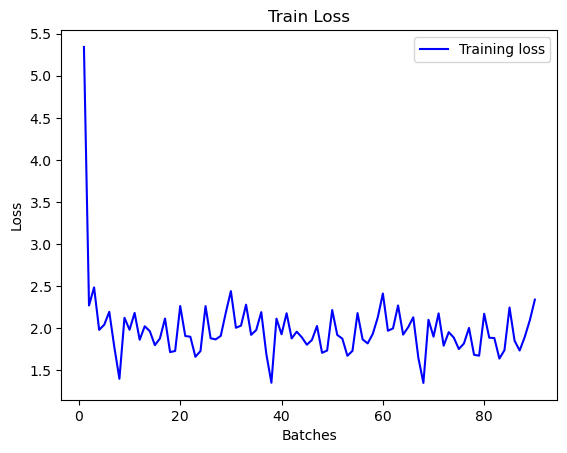

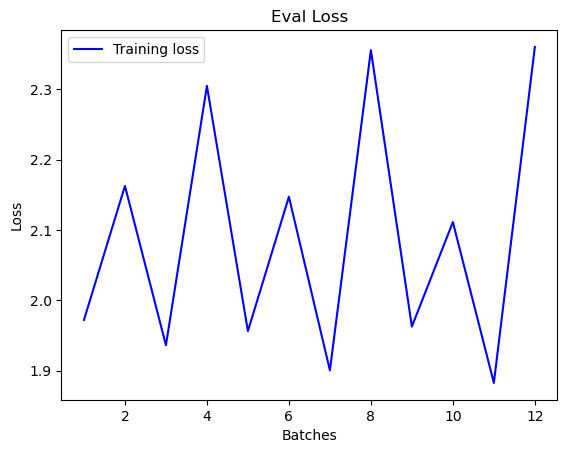

Best development accuracy improved from 0.4056329131126404 to 0.4082673192024231, saving model...

--- Training model Epoch: 4 ---
Training Iteration 0 of epoch 3 complete. Loss: 1.9503703117370605; Acc:0.47265625; Time taken (s): 21.78550958633423
Training Iteration 1000 of epoch 3 complete. Loss: 1.9890460968017578; Acc:0.41796875; Time taken (s): 1.4260005950927734
Training Iteration 2000 of epoch 3 complete. Loss: 2.3024678230285645; Acc:0.33984375; Time taken (s): 1.1890008449554443
Training Iteration 3000 of epoch 3 complete. Loss: 1.9142009019851685; Acc:0.4453125; Time taken (s): 1.2260005474090576
Training Iteration 4000 of epoch 3 complete. Loss: 2.0311877727508545; Acc:0.40625; Time taken (s): 1.2290012836456299
Training Iteration 5000 of epoch 3 complete. Loss: 2.1213700771331787; Acc:0.359375; Time taken (s): 1.2150003910064697
Training Iteration 6000 of epoch 3 complete. Loss: 1.6609898805618286; Acc:0.53515625; Time taken (s): 1.2150015830993652
Training Iteration 7000 o

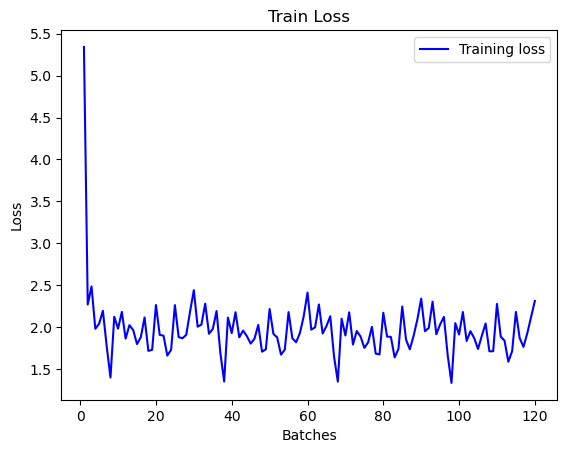

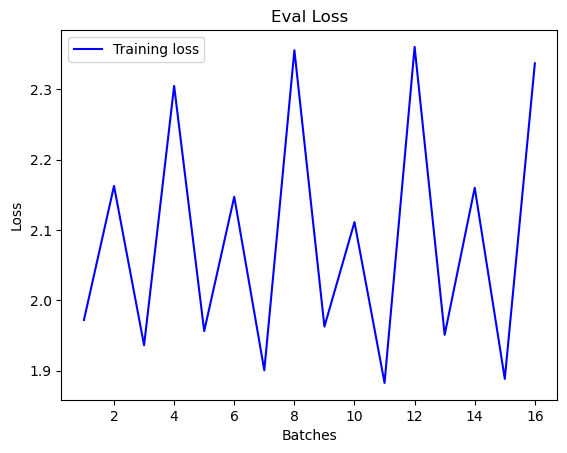

Best development accuracy improved from 0.4082673192024231 to 0.4097992181777954, saving model...

--- Training model Epoch: 5 ---
Training Iteration 0 of epoch 4 complete. Loss: 1.9202903509140015; Acc:0.5078125; Time taken (s): 21.806784868240356
Training Iteration 1000 of epoch 4 complete. Loss: 2.0115489959716797; Acc:0.40625; Time taken (s): 1.4127800464630127
Training Iteration 2000 of epoch 4 complete. Loss: 2.258923292160034; Acc:0.34765625; Time taken (s): 1.1920015811920166
Training Iteration 3000 of epoch 4 complete. Loss: 1.8943146467208862; Acc:0.41796875; Time taken (s): 1.1827149391174316
Training Iteration 4000 of epoch 4 complete. Loss: 2.00299334526062; Acc:0.4140625; Time taken (s): 1.1670005321502686
Training Iteration 5000 of epoch 4 complete. Loss: 2.1500723361968994; Acc:0.3671875; Time taken (s): 1.1600008010864258
Training Iteration 6000 of epoch 4 complete. Loss: 1.7142019271850586; Acc:0.5078125; Time taken (s): 1.1900010108947754
Training Iteration 7000 of e

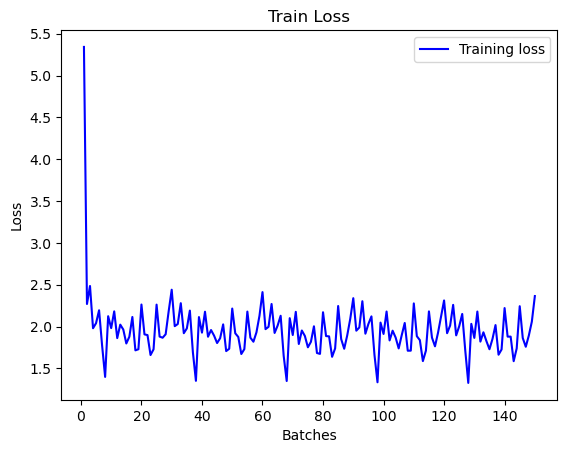

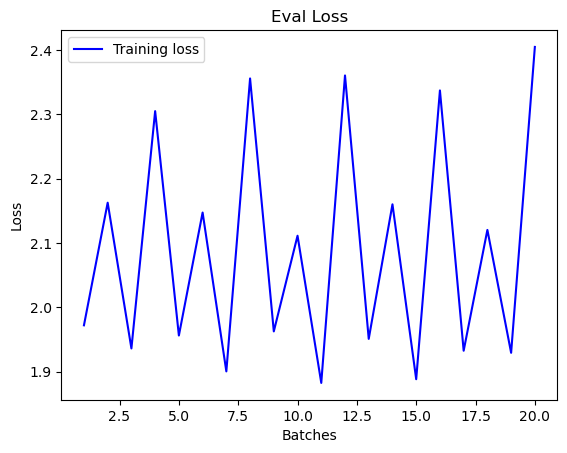

Best development accuracy improved from 0.4097992181777954 to 0.4130763113498688, saving model...

--- Training model Epoch: 6 ---
Training Iteration 0 of epoch 5 complete. Loss: 1.9144924879074097; Acc:0.484375; Time taken (s): 21.405810594558716
Training Iteration 1000 of epoch 5 complete. Loss: 2.029705286026001; Acc:0.421875; Time taken (s): 1.476001262664795
Training Iteration 2000 of epoch 5 complete. Loss: 2.2783405780792236; Acc:0.33984375; Time taken (s): 1.2310004234313965
Training Iteration 3000 of epoch 5 complete. Loss: 1.9107574224472046; Acc:0.4765625; Time taken (s): 1.2570011615753174
Training Iteration 4000 of epoch 5 complete. Loss: 1.949019432067871; Acc:0.41796875; Time taken (s): 1.2350010871887207
Training Iteration 5000 of epoch 5 complete. Loss: 2.1797521114349365; Acc:0.34375; Time taken (s): 1.2289998531341553
Training Iteration 6000 of epoch 5 complete. Loss: 1.6734492778778076; Acc:0.5234375; Time taken (s): 1.2390015125274658
Training Iteration 7000 of epo

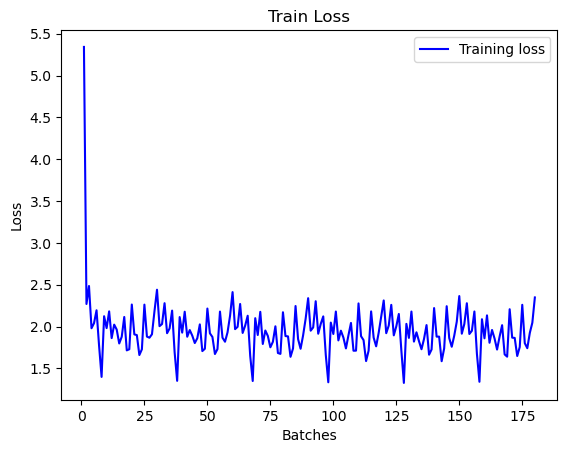

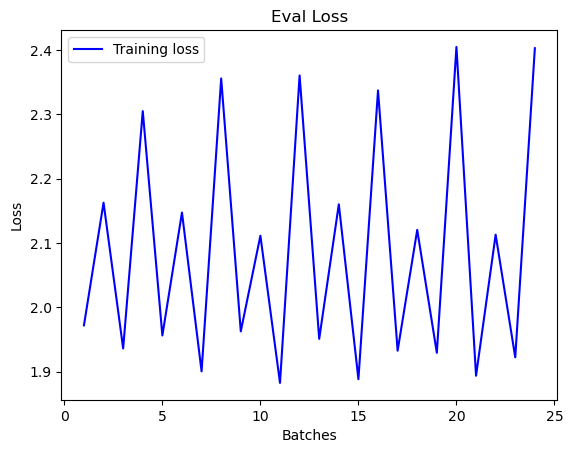

Best development accuracy improved from 0.4130763113498688 to 0.4138745665550232, saving model...

--- Training model Epoch: 7 ---
Training Iteration 0 of epoch 6 complete. Loss: 1.8907010555267334; Acc:0.46484375; Time taken (s): 21.867234468460083
Training Iteration 1000 of epoch 6 complete. Loss: 1.9944502115249634; Acc:0.41015625; Time taken (s): 1.3800013065338135
Training Iteration 2000 of epoch 6 complete. Loss: 2.2827014923095703; Acc:0.3671875; Time taken (s): 1.1970007419586182
Training Iteration 3000 of epoch 6 complete. Loss: 1.9205026626586914; Acc:0.4609375; Time taken (s): 1.1890008449554443
Training Iteration 4000 of epoch 6 complete. Loss: 1.954797387123108; Acc:0.4296875; Time taken (s): 1.147000789642334
Training Iteration 5000 of epoch 6 complete. Loss: 2.143101692199707; Acc:0.37109375; Time taken (s): 1.1950008869171143
Training Iteration 6000 of epoch 6 complete. Loss: 1.6694161891937256; Acc:0.51953125; Time taken (s): 1.1680006980895996
Training Iteration 7000 

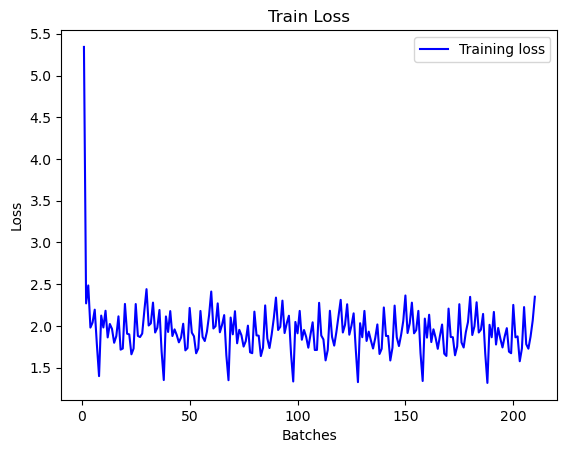

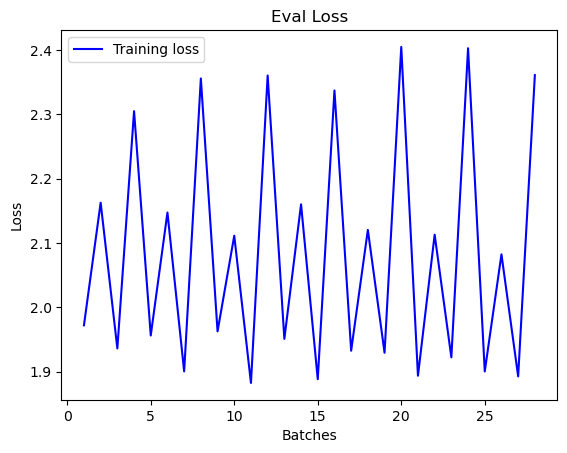

Best development accuracy improved from 0.4138745665550232 to 0.4156772494316101, saving model...

--- Training model Epoch: 8 ---
Training Iteration 0 of epoch 7 complete. Loss: 1.8866682052612305; Acc:0.4765625; Time taken (s): 21.696413040161133
Training Iteration 1000 of epoch 7 complete. Loss: 2.0174307823181152; Acc:0.40234375; Time taken (s): 1.3536996841430664
Training Iteration 2000 of epoch 7 complete. Loss: 2.266763210296631; Acc:0.34375; Time taken (s): 1.1780006885528564
Training Iteration 3000 of epoch 7 complete. Loss: 1.9186246395111084; Acc:0.4375; Time taken (s): 1.194000005722046
Training Iteration 4000 of epoch 7 complete. Loss: 1.9546494483947754; Acc:0.44140625; Time taken (s): 1.2010009288787842
Training Iteration 5000 of epoch 7 complete. Loss: 2.1149017810821533; Acc:0.3671875; Time taken (s): 1.1790010929107666
Training Iteration 6000 of epoch 7 complete. Loss: 1.6556614637374878; Acc:0.5390625; Time taken (s): 1.203000783920288
Training Iteration 7000 of epoc

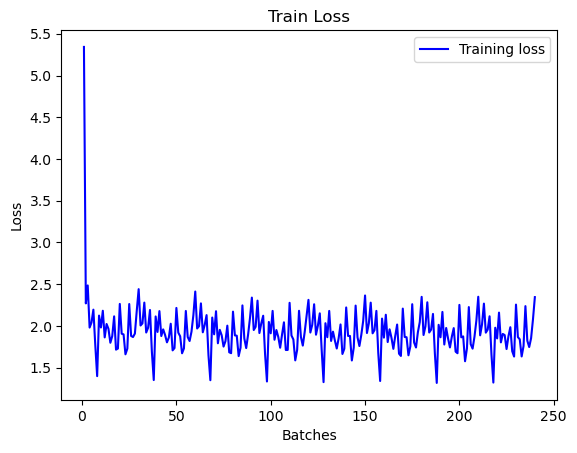

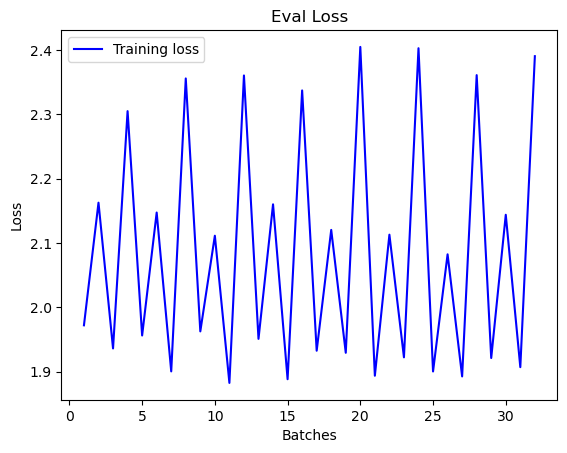

In [34]:
# Using negative log-likelihood loss
loss_function = nn.NLLLoss()

# create model
model = fiveGramNNmodel(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE, H)

# load it to gpu
model.cuda(gpu)

# using ADAM optimizer
optimizer = optim.Adam(model.parameters(), lr = 2e-3)


# ------------------------- TRAIN & SAVE MODEL ------------------------
best_acc = 0
best_model_path = None
train_losses = []
eval_losses = []
for epoch in range(8):
    st = time.time()
    print("\n--- Training model Epoch: {} ---".format(epoch+1))
    for it, data_tensor in enumerate(train_loader):       
        context_tensor = data_tensor[:,0:4].type(torch.LongTensor)
        target_tensor = data_tensor[:,4].type(torch.LongTensor)

        context_tensor, target_tensor = context_tensor.to(device), target_tensor.to(device)

        # zero out the gradients from the old instance
        model.zero_grad()

        # get log probabilities over next words
        log_probs = model(context_tensor)

        # calculate current accuracy
        acc = get_accuracy_from_log_probs(log_probs, target_tensor)

        # compute loss function
        loss = loss_function(log_probs, target_tensor)

        # backward pass and update gradient
        loss.backward()
        optimizer.step()

        if it % 1000 == 0: 
            print("Training Iteration {} of epoch {} complete. Loss: {}; Acc:{}; Time taken (s): {}".format(it, epoch, loss.item(), acc, (time.time()-st)))
            train_losses.append(loss.item())
            st = time.time()

    print("\n--- Evaluating model on dev data ---")
    dev_acc, dev_loss, e_losses = evaluate(model, loss_function, test_loader, gpu)
    eval_losses = eval_losses + e_losses
    print("Epoch {} complete! Development Accuracy: {}; Development Loss: {}".format(epoch, dev_acc, dev_loss))
    
    plot_loss(train_losses, "Train Loss")
    plot_loss(eval_losses, "Eval Loss")
    
    if dev_acc > best_acc:
        print("Best development accuracy improved from {} to {}, saving model...".format(best_acc, dev_acc))
        best_acc = dev_acc
        # set best model path
        best_model_path = 'models/best_char_fivegram_model_{}.dat'.format(epoch)
        # saving best model
        torch.save(model.state_dict(), best_model_path)